## _Processing Stage_

In [1]:
import glob, os, sys, yaml

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pprint
import seaborn as sns
import trackml.dataset

In [4]:
import torch
from torch_geometric.data import Data
import itertools

In [5]:
# append parent dir
# sys.path.append('src')

In [6]:
from src import compose_event, draw_event

In [7]:
# set EXATRKX_DATA env variable
os.environ['EXATRKX_DATA'] = os.path.abspath(os.curdir)

In [8]:
# select a device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### _Config File_
---

In [9]:
# load processing config file (trusted source)
config_file = os.path.join(os.curdir, 'LightningModules/Processing/configs/prepare_quickstart.yaml')
with open(config_file) as f:
    try:
        config = yaml.load(f, Loader=yaml.FullLoader) # equiv: yaml.full_load(f)
    except yaml.YAMLError as e:
        print(e)

In [10]:
# see params used in this stage
pp = pprint.PrettyPrinter(indent=2)
pp.pprint(config)

{ 'input_dir': '${EXATRKX_DATA}/train_all',
  'inputedges': True,
  'layerwise': True,
  'modulewise': True,
  'n_files': 1000,
  'n_tasks': 1,
  'n_workers': 8,
  'noise': True,
  'output_dir': '${EXATRKX_DATA}/run/feature_store',
  'overwrite': True,
  'skewed': False}


In [11]:
# change some params here
config['n_files'] = 10
config['train_split'] = [8, 1, 1]
config['regime'] = ['rp', 'hnm']

In [12]:
# see params used in this stage
pp = pprint.PrettyPrinter(indent=2)
pp.pprint(config)

{ 'input_dir': '${EXATRKX_DATA}/train_all',
  'inputedges': True,
  'layerwise': True,
  'modulewise': True,
  'n_files': 10,
  'n_tasks': 1,
  'n_workers': 8,
  'noise': True,
  'output_dir': '${EXATRKX_DATA}/run/feature_store',
  'overwrite': True,
  'regime': ['rp', 'hnm'],
  'skewed': False,
  'train_split': [8, 1, 1]}


## _(1) - Input Data_
---

In [13]:
event_id = 1

In [14]:
# Fetch an event, use event_id (int)
# prefix = "event{:010d}".format(event_id)                     # make a prefix, OR
# prefix = str('event{!s}'.format(format(event_id, '010d')))   # make a prefix
# INPUT_DATA = os.path.expandvars(config['input_dir'])         # input data directory
# event_prefix = os.path.join(INPUT_DATA, prefix)              # event_prefix ~ event_file = input_dir + prefix

In [15]:
# hits, tubes, particles, truth = trackml.dataset.load_event(event_prefix)

### _(+) - Plotting Event_

In [16]:
# event = compose_event(event_prefix,skewed=True)
# draw_event(event,figsize=(8,8),save_fig=False);

## _(2) - Processed Data_
---

In [17]:
#from LightningModules.Processing.utils.event_utils import graph_intersection
#from LightningModules.Processing.utils.draw_utils import draw_proc_event, cylindrical_to_cartesian

In [18]:
from LightningModules.Processing import graph_intersection, draw_proc_event, cylindrical_to_cartesian

In [19]:
# Path to feature_store, use os.path.expandvars for ${HOME}
FEATURE_DATA = os.path.expandvars(config['output_dir'])
print("FEATURE_DATA: {}".format(os.path.basename(FEATURE_DATA)))

FEATURE_DATA: feature_store


In [20]:
# examine an event, give integer value to event_id
feature_data = torch.load(os.path.join(FEATURE_DATA, str(event_id)), map_location=device)
print("Length of Data: {}".format(len(feature_data)))

Length of Data: 10


In [21]:
feature_data

Data(x=[164, 3], pid=[164], layers=[164], event_file='/home/adeak977/current/3_deeptrkx/stttrkx-hsf/train_all/event0000000001', hid=[164], pt=[164], modulewise_true_edges=[2, 154], layerwise_true_edges=[2, 171], edge_index=[2, 896], y_pid=[896])

In [22]:
# x=[r,phi,isochrone]
feature_data.x.shape

torch.Size([164, 3])

In [23]:
feature_data.modulewise_true_edges.shape

torch.Size([2, 154])

In [24]:
feature_data.layerwise_true_edges.shape

torch.Size([2, 171])

In [25]:
feature_data.edge_index.shape

torch.Size([2, 896])

In [26]:
feature_data.pid.shape

torch.Size([164])

In [27]:
feature_data.y_pid.shape

torch.Size([896])

In [28]:
feature_data.event_file

'/home/adeak977/current/3_deeptrkx/stttrkx-hsf/train_all/event0000000001'

In [29]:
# event prefix from data
feature_data.event_file[-15:]

'event0000000001'

In [30]:
# event ID from data
int(feature_data.event_file[-10:])

1

In [31]:
# recreate event prefix from event ID
str('event{!s}'.format(format(event_id, '010d')))

'event0000000001'

In [32]:
# OR, recreate event prefix from event ID
"event{:010d}".format(1)

'event0000000001'

In [33]:
# event file
os.path.join(os.path.dirname(feature_data.event_file), "event{:010d}".format(1))

'/home/adeak977/current/3_deeptrkx/stttrkx-hsf/train_all/event0000000001'

### _(+) - Plotting Event_

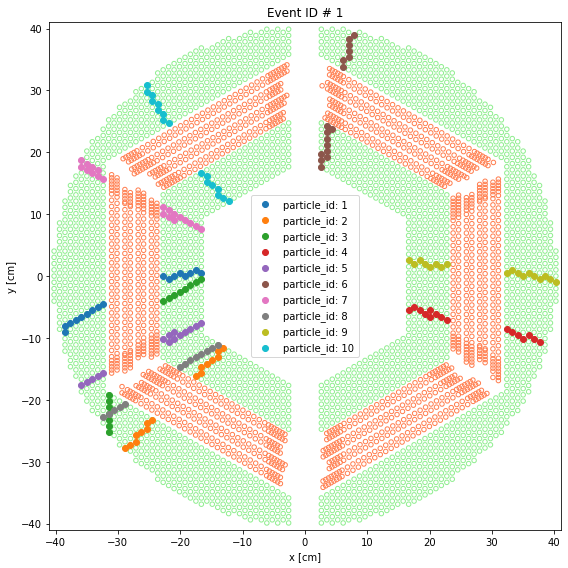

In [34]:
# draw a processed event
draw_proc_event(feature_data, figsize=(8,8), save_fig=False);

## _(3) - Plotting Edges_

- Input Edges/Graph
- Ground Truth of Input Edges (layerwise_true_edges)

### _(+) - Plotting Input Edges_

In [35]:
# examine data
pp.pprint(feature_data)

Data(x=[164, 3], pid=[164], layers=[164], event_file='/home/adeak977/current/3_deeptrkx/stttrkx-hsf/train_all/event0000000001', hid=[164], pt=[164], modulewise_true_edges=[2, 154], layerwise_true_edges=[2, 171], edge_index=[2, 896], y_pid=[896])


In [36]:
# get input_edges (both true & fake)
input_edges = feature_data.edge_index

In [37]:
input_edges[0][:15]

tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2])

In [38]:
input_edges[1][:15]

tensor([ 5,  6, 12, 17, 20, 25, 26,  5,  6, 12, 17, 20, 25, 26,  8])

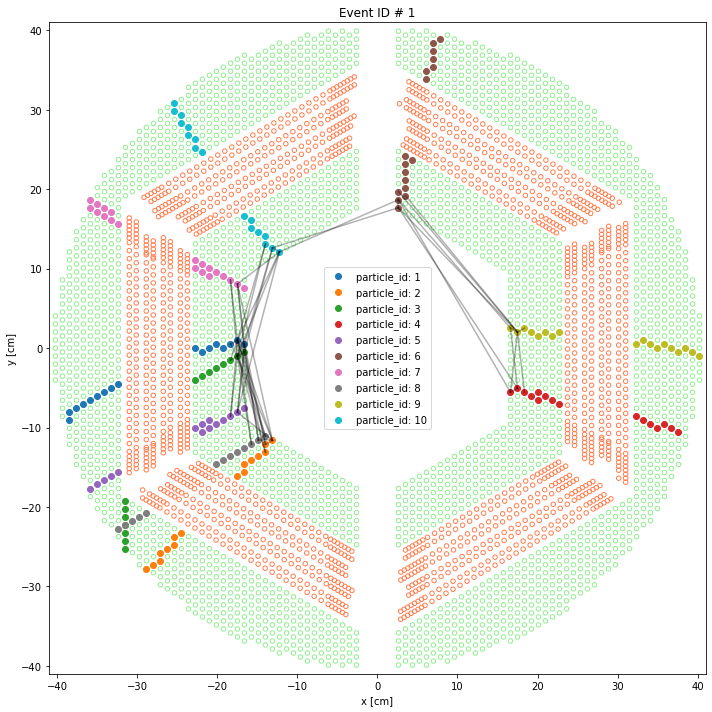

In [39]:
# plotting input_edges
plt.close('all')

# init subplots
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

# detector layout
det = pd.read_csv("src/stt.csv")
skw = det.query('skewed==0')
nkw = det.query('skewed==1') # one may look for +ve/-ve polarity
plt.scatter(skw.x.values, skw.y.values, s=20, facecolors='none', edgecolors='lightgreen')
plt.scatter(nkw.x.values, nkw.y.values, s=20, facecolors='none', edgecolors='coral')

# feature data
x,y,_ = cylindrical_to_cartesian(r=feature_data.x[:, 0], phi=feature_data.x[:, 1], z=feature_data.x[:, 2])
    
# particle tracks
p_ids = np.unique(feature_data.pid)
for pid in p_ids:
    idx = feature_data.pid == pid
    ax.scatter(x[idx], y[idx], label='particle_id: %d' %pid)
    
# input edges
#for iedge in range(edge_index.shape[1]):
for iedge in range(56):
    ptx1 = x[input_edges[0][iedge]]
    ptx2 = x[input_edges[1][iedge]]
    pty1 = y[input_edges[0][iedge]]
    pty2 = y[input_edges[1][iedge]]
    ax.plot([ptx1, ptx2], [pty1, pty2], color='k', alpha=0.3, lw=1.5)

# plotting params
ax.set_title('Event ID # %d' % event_id)
ax.set_xlabel('x [cm]', fontsize=10)
ax.set_ylabel('y [cm]', fontsize=10)
ax.set_xlim(-41, 41)
ax.set_ylim(-41, 41)
ax.grid(False)
ax.legend(fontsize=10, loc='best')
fig.tight_layout()
# fig.savefig("input_edges.png")

### _(+) - Plotting True Edges_

In _feature_data_, we have _`layerwise_true_edges`_, _`modulewise_true_edges`_ and _`edge_index`_ (_a.k.a_ input graph). The `edge_index` contains both `true` and `false` edges. However, we have `edge_index` truth as `y` or `y_pid`. So by using `y_pid==1(0)` one can query only `true (false)` edges.

Let's separate true edges:

In [40]:
feature_data.edge_index

tensor([[  0,   0,   0,  ..., 163, 163, 163],
        [  5,   6,  12,  ..., 126, 136, 156]])

In [41]:
# get index of true (false) edges by setting y_pid=True(False)
idx = np.where(feature_data.y_pid==True)[0]

In [42]:
idx.shape

(171,)

In [43]:
# get true edges equiv to layerwise_true_edges
input_edges = feature_data.edge_index.T[idx].T

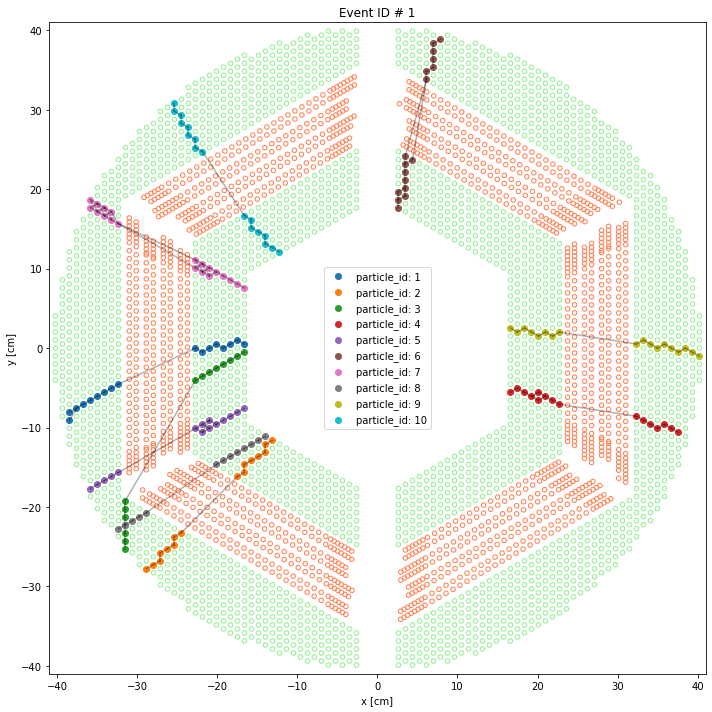

In [44]:
# plotting input_edges
plt.close('all')

# init subplots
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

# detector layout
det = pd.read_csv("src/stt.csv")
skw = det.query('skewed==0')
nkw = det.query('skewed==1') # one may look for +ve/-ve polarity
plt.scatter(skw.x.values, skw.y.values, s=20, facecolors='none', edgecolors='lightgreen')
plt.scatter(nkw.x.values, nkw.y.values, s=20, facecolors='none', edgecolors='coral')

# feature data
x,y,_ = cylindrical_to_cartesian(r=feature_data.x[:, 0], phi=feature_data.x[:, 1], z=feature_data.x[:, 2])
    
# particle tracks
p_ids = np.unique(feature_data.pid)
for pid in p_ids:
    idx = feature_data.pid == pid
    ax.scatter(x[idx], y[idx], label='particle_id: %d' %pid)
    
# input edges
for iedge in range(input_edges.shape[1]):
#for iedge in range(56):
    ptx1 = x[input_edges[0][iedge]]
    ptx2 = x[input_edges[1][iedge]]
    pty1 = y[input_edges[0][iedge]]
    pty2 = y[input_edges[1][iedge]]
    ax.plot([ptx1, ptx2], [pty1, pty2], color='k', alpha=0.3, lw=1.5)

# plotting params
ax.set_title('Event ID # %d' % event_id)
ax.set_xlabel('x [cm]', fontsize=10)
ax.set_ylabel('y [cm]', fontsize=10)
ax.set_xlim(-41, 41)
ax.set_ylim(-41, 41)
ax.grid(False)
ax.legend(fontsize=10, loc='best')
fig.tight_layout()
# fig.savefig("input_edges.png")

### _(+) - Plotting False Edges_

In _feature_data_, we have _`layerwise_true_edges`_, _`modulewise_true_edges`_ and _`edge_index`_ (_a.k.a_ input graph). The `edge_index` contains both `true` and `false` edges. However, we have `edge_index` truth as `y` or `y_pid`. So by using `y_pid==1(0)` one can query only `true (false)` edges.

Let's separate false edges:

In [45]:
# get index of true (false) edges by setting y_pid=True(False)
idx = np.where(feature_data.y_pid==False)[0]

In [46]:
idx.shape

(725,)

In [47]:
# get true edges equiv to layerwise_true_edges
input_edges = feature_data.edge_index.T[idx].T

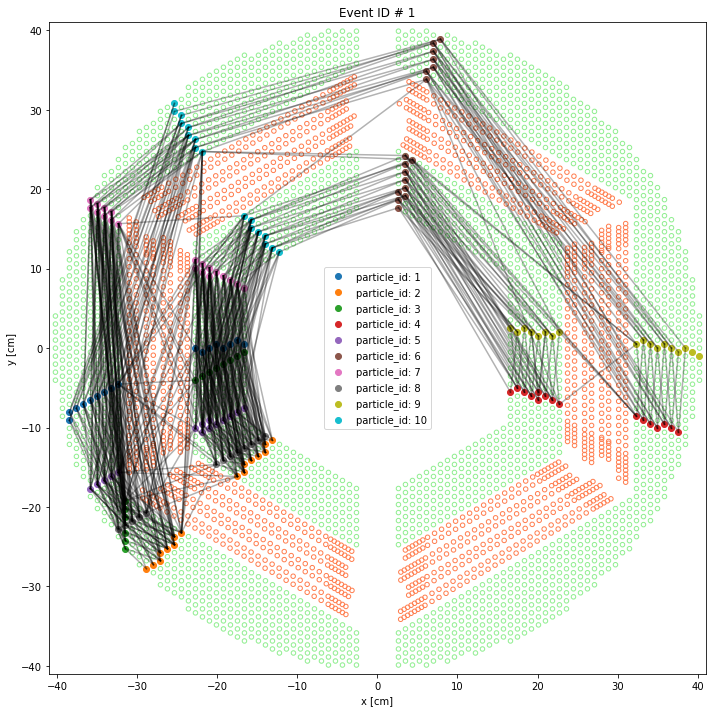

In [48]:
# plotting input_edges
plt.close('all')

# init subplots
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

# detector layout
det = pd.read_csv("src/stt.csv")
skw = det.query('skewed==0')
nkw = det.query('skewed==1') # one may look for +ve/-ve polarity
plt.scatter(skw.x.values, skw.y.values, s=20, facecolors='none', edgecolors='lightgreen')
plt.scatter(nkw.x.values, nkw.y.values, s=20, facecolors='none', edgecolors='coral')

# feature data
x,y,_ = cylindrical_to_cartesian(r=feature_data.x[:, 0], phi=feature_data.x[:, 1], z=feature_data.x[:, 2])
    
# particle tracks
p_ids = np.unique(feature_data.pid)
for pid in p_ids:
    idx = feature_data.pid == pid
    ax.scatter(x[idx], y[idx], label='particle_id: %d' %pid)
    
# input edges
for iedge in range(input_edges.shape[1]):
#for iedge in range(56):
    ptx1 = x[input_edges[0][iedge]]
    ptx2 = x[input_edges[1][iedge]]
    pty1 = y[input_edges[0][iedge]]
    pty2 = y[input_edges[1][iedge]]
    ax.plot([ptx1, ptx2], [pty1, pty2], color='k', alpha=0.3, lw=1.5)

# plotting params
ax.set_title('Event ID # %d' % event_id)
ax.set_xlabel('x [cm]', fontsize=10)
ax.set_ylabel('y [cm]', fontsize=10)
ax.set_xlim(-41, 41)
ax.set_ylim(-41, 41)
ax.grid(False)
ax.legend(fontsize=10, loc='best')
fig.tight_layout()
# fig.savefig("input_edges.png")